In [1]:
import os
from glob import glob
from pandas import DataFrame
import pandas as pd
import configparser
import subprocess as sp
import matplotlib.pyplot as plt
import pprint

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [11]:
%matplotlib inline

In [3]:

bench_start = '2018-12-01_09:07:42'
bench_end = '2018-12-01_11:48:24'

experiments_path = '/home/dongwonshin/Desktop/SLAM_eval/Experiment_Results'
all_benchmarks = sorted(glob('%s/*' % experiments_path))

# benchmark filtereing
filtered_benchmarks = []
for benchmark in all_benchmarks:
    if (bench_start <= benchmark.split('/')[-1] and benchmark.split('/')[-1] <= bench_end):
        filtered_benchmarks.append(benchmark)

segmap_config_table = DataFrame()
for benchmark in filtered_benchmarks:
    config = configparser.ConfigParser()
    config.read(os.path.join(benchmark, 'POI.ini'))
    target_kitti_data = config.get('PARAMETERS','target_kitti_data')
    icp_config = config.get('PARAMETERS','icp_config')
    odom_config = config.get('PARAMETERS','odom_config')

    segmap_config_table = segmap_config_table.append({"benchmark_path": benchmark.split('/')[-1],
                                                      "target_kitti_data": target_kitti_data, 
                                                      "icp_config": icp_config, 
                                                      "odom_config" : odom_config}, ignore_index = True)

In [4]:
segmap_config_table

,benchmark_path,icp_config,odom_config,target_kitti_data
0,2018-12-01_09:07:42,semantic_icp,with_odom,0
1,2018-12-01_09:15:41,semantic_icp,without_odom,0
2,2018-12-01_09:23:39,ordinary_icp,with_odom,0
3,2018-12-01_09:31:37,ordinary_icp,without_odom,0
4,2018-12-01_09:33:47,semantic_icp,with_odom,1
5,2018-12-01_09:35:53,semantic_icp,without_odom,1
6,2018-12-01_09:38:00,ordinary_icp,with_odom,1
7,2018-12-01_09:40:06,ordinary_icp,without_odom,1
8,2018-12-01_09:48:16,semantic_icp,with_odom,2
9,2018-12-01_09:56:35,semantic_icp,without_odom,2


In [5]:
from evo.tools import log
log.configure_logging(verbose=False, debug=False, silent=True)

import pprint
import numpy as np

from evo.tools import plot
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib notebook

# temporarily override some package settings
from evo.tools.settings import SETTINGS
SETTINGS.plot_usetex = False

from evo.tools import file_interface
from evo.core import sync
from evo.core import trajectory
from evo.core import metrics

import itertools

In [6]:
def absolute_trajectory_error(ref_file, est_file, eval_type):
    traj_ref = file_interface.read_tum_trajectory_file(ref_file)
    traj_est = file_interface.read_tum_trajectory_file(est_file)

    max_diff = 0.01

    traj_ref, traj_est = sync.associate_trajectories(traj_ref, traj_est, max_diff)
    traj_est_aligned = trajectory.align_trajectory(traj_est, traj_ref, correct_scale=True)

    if (eval_type=='translation'):
        pose_relation = metrics.PoseRelation.translation_part
    elif (eval_type=='rotation'):
        pose_relation = metrics.PoseRelation.rotation_part

    data = (traj_ref, traj_est_aligned) 

    ape_metric = metrics.APE(pose_relation)
    ape_metric.process_data(data)

    ape_stat = ape_metric.get_statistic(metrics.StatisticsType.rmse)
    
    return ape_stat/traj_ref.get_infos()['path length (m)']

In [7]:
def result_for_conditions(odom_config, icp_config, verbose):
    
    if (verbose):
        print(odom_type, ',', icp_config)

    target_table = segmap_config_table[
                        (segmap_config_table['odom_config']==odom_config)
                      & (segmap_config_table['icp_config']==icp_config)
                    ]

    t_result_list = []
    r_result_list = []
    for index, row in target_table.iterrows():

        if (verbose):
            print('target kitti data : ', row['target_kitti_data'])
        benchmark_path = row['benchmark_path']
        target_kitti_data =  row['target_kitti_data']

        ref_file = "/home/dongwonshin/Downloads/dataset/poses/%02d_time.txt" % int(target_kitti_data)
        est_file = "/home/dongwonshin/Desktop/SLAM_eval/Experiment_Results/%s/trajectory.csv" % benchmark_path

        translation_error = absolute_trajectory_error(ref_file, est_file, 'translation')
        rotation_error = absolute_trajectory_error(ref_file, est_file, 'rotation')

        if (verbose):
            print('translation error \t', translation_error)
            print('rotation error \t\t', rotation_error)

        t_result_list.append(translation_error)
        r_result_list.append(rotation_error)
        
    return t_result_list, r_result_list

In [8]:
odom_configs = ['with_odom', 'without_odom']
icp_configs = ['ordinary_icp', 'semantic_icp']

translation_error_list = {}
rotation_error_list = {}
for odom_config, icp_config in itertools.product(odom_configs, icp_configs):
    t_result_list, r_result_list = result_for_conditions(odom_config, icp_config,verbose=False)
    translation_error_list[odom_config + '_' + icp_config] = t_result_list
    rotation_error_list[odom_config + '_' + icp_config] = r_result_list

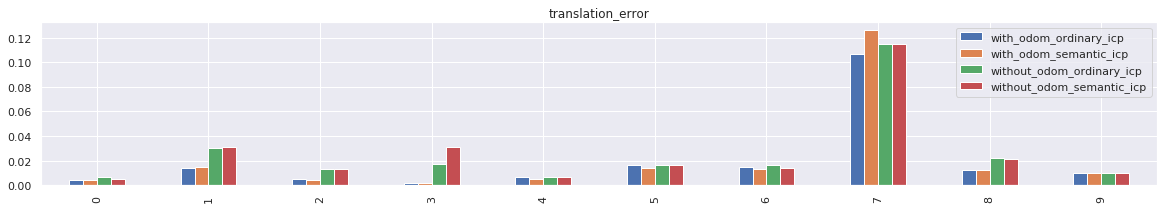

In [12]:
translation_error_df = pd.DataFrame.from_dict(translation_error_list)
plt.rcParams["figure.figsize"] = (20,3)
translation_error_df.plot(kind = 'bar')
plt.title('translation_error')
plt.show()

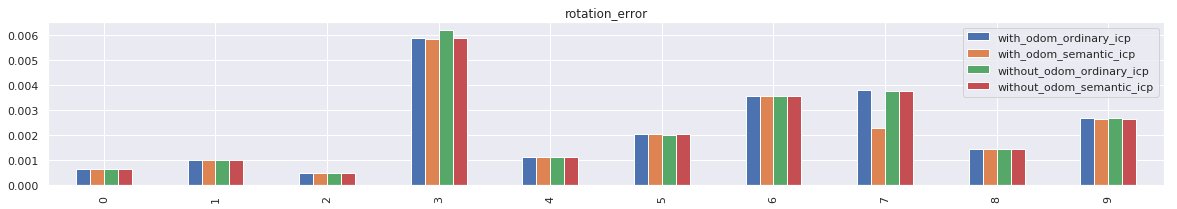

In [13]:
rotation_error_df = pd.DataFrame.from_dict(rotation_error_list)
plt.rcParams["figure.figsize"] = (20,3)
rotation_error_df.plot(kind = 'bar')
plt.title('rotation_error')
plt.show()

In [14]:
translation_error_df

,with_odom_ordinary_icp,with_odom_semantic_icp,without_odom_ordinary_icp,without_odom_semantic_icp
0,0.004358,0.004027,0.006615,0.005080
1,0.013835,0.014899,0.030642,0.031327
2,0.004893,0.004566,0.013313,0.012976
3,0.002095,0.002124,0.017207,0.031257
4,0.006780,0.005170,0.006882,0.006345
5,0.016460,0.014353,0.016491,0.016135
6,0.014579,0.012911,0.016161,0.013886
7,0.106318,0.126128,0.114438,0.114380
8,0.012067,0.012346,0.021926,0.021486
9,0.010327,0.010199,0.010327,0.010199


In [15]:
rotation_error_df

,with_odom_ordinary_icp,with_odom_semantic_icp,without_odom_ordinary_icp,without_odom_semantic_icp
0,0.000662,0.000662,0.000662,0.000662
1,0.000994,0.000994,0.000987,0.000987
2,0.000485,0.000485,0.000486,0.000488
3,0.005850,0.005842,0.006182,0.005850
4,0.001118,0.001116,0.001116,0.001117
5,0.002031,0.002029,0.002017,0.002029
6,0.003536,0.003537,0.003535,0.003541
7,0.003800,0.002274,0.003754,0.003746
8,0.001436,0.001437,0.001433,0.001433
9,0.002662,0.002657,0.002662,0.002657


In [16]:
translation_error_df.mean()

with_odom_ordinary_icp       0.019171
with_odom_semantic_icp       0.020672
without_odom_ordinary_icp    0.025400
without_odom_semantic_icp    0.026307
dtype: float64

In [17]:
rotation_error_df.mean()

with_odom_ordinary_icp       0.002257
with_odom_semantic_icp       0.002103
without_odom_ordinary_icp    0.002283
without_odom_semantic_icp    0.002251
dtype: float64